In [6]:
# Required pkg
import Pkg;
Pkg.add("Images")
Pkg.add("LinearAlgebra")
Pkg.add("Plots")
Pkg.add("Interpolations")
Pkg.add("DataFrames")
Pkg.add("XLSX")
using Images, Statistics, LinearAlgebra, Plots, Interpolations, Random, DataFrames, XLSX

    Updating registry at `C:\Users\s2kjn\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s2kjn\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes t

### [Auxiliary functions] to get: training_images, testing_images
#### Each with a size = M * N^2

M = Number of images (min_images_per_folder)

N^2 = A vector of the original image_size*image_size image

In [7]:
# Get useful folders

# Return a Vector{String} with all the folders with {min_images_per_folder} inside.
function get_useful_folders(min_images)
    ### Getting images
    useful_folders = Vector{String}()
    
    itr = walkdir(base_dir)    
    (root, dirs, files) = first(itr)
    for d in dirs
        images_on_folder = readdir(base_dir * d)
        if size(images_on_folder)[1] >= min_images
            push!(useful_folders, base_dir * d * "/")
        end
    end
    useful_folders
end

# After filter by get_useful_folders(), get random {n_folders}
function get_random_n_folders(min_images_per_folder)
    # Get all the useful folders
    useful_folders = get_useful_folders(min_images_per_folder)
    # Get random folders from {useful_folders}
    rand(useful_folders, n_folders)
end

# Get all images from {n_folders} random folders, each case for {training_images} and {testing_images}
# Return a Matrix, size = M * N^2
#     M = Number of images (min_images_per_folder)
#     N^2 = A row vector of the original N*N image (now: 1*N^2)

function get_images(float_type, working_with=nothing)
    
    # Pick {n_folders} to work with if {working_with} not provided
    if working_with === nothing
       working_with = get_random_n_folders(min_images_per_folder)
    end    
        
    training_images = zeros(float_type, size(working_with, 1)*n_training_images,  image_size*image_size)
    testing_images = zeros(float_type, size(working_with, 1)*n_testing_images,  image_size*image_size)
    
    # For every folder, get pictures
    for (i, folder) in enumerate(working_with)
        cdir = readdir(folder)        
        
        # Google Drive create a "desktop.ini", then I have to "findfirst" and delete element
        splice!(cdir, findfirst(contains("desktop.ini"), cdir))
            
        training_count = 1
        testing_count = 1

        for image_relative_path in cdir 
            
            row_im = vec(float_type.(Gray.( imresize(load(folder * image_relative_path), image_size, image_size) )))' # 1 x N*N
            #display(Gray.(load(folder * image_relative_path)))
            
            if training_count <= n_training_images
                training_images[ (n_training_images*(i-1) + training_count),:] = row_im
                training_count += 1
            elseif testing_count <= n_testing_images
                testing_images[ (n_testing_images*(i-1) + testing_count),:] = row_im
                testing_count += 1
            else
                break  # Stop here if both training and testing images are collected
            end
        end
    end
    (training_images, testing_images)
end

get_images (generic function with 2 methods)

In [8]:
function show_training_images(images)
    for i in 1:n_folders
        row = vcat([ Gray.(reshape(images[j,:], image_size, image_size)) for j in (n_training_images*(i-1))+1:((n_training_images*(i-1))+n_training_images)])
        display(row)
    end    
end

function show_testing_images(images)
    for i in 1:n_folders
        row = vcat([ Gray.(reshape(images[j,:], image_size, image_size)) for j in (n_testing_images*(i-1))+1:((n_testing_images*(i-1))+n_testing_images)])
        display(row)
    end    
end

show_testing_images (generic function with 1 method)

# Getting the basics

### μ, A, C, eigenvalues, eigenvectors

#### n_folders
Number of folders to use, randomly selected. **Between 1 and _size(get_useful_folders(n_folders), 1)_**

#### n_training_images
Number of training images to pick from every folder

#### n_testing_images
Same but for testing

#### min_images_per_folder
Before, it will filter the folders on the directory by {min_images_per_folder}

In [118]:
# ./lfw/  = Color, not aligned
# ./lfw2/ = Black and white, already aligned (eyes)
base_dir = "./lfw/" 
image_size = 64

n_folders = 10
n_training_images = 12
n_testing_images = 6

min_images_per_folder = n_training_images + n_testing_images + 1; # +1 because google drive creating desktop.ini

#### (training_images, testing_images), μ, A, eigenvalues, eigenvectors, elapsed_time, mem_used

In [169]:
function setup_basics(float_type, folders=nothing)
    (training_images, testing_images) = get_images(float_type, folders)
    
    # Mean
    μ = mean(training_images, dims = 1)

    # Centered matrix
    A = training_images.-μ

    # Covariance (N2xN2) and eigen
    run_block = @timed begin
        (eigenvalues, eigenvectors) = eigen(cov(A), sortby = x -> -x)
    end
    
    (eigenvalues, eigenvectors) = run_block.value # Again
    elapsed_time = run_block.time
    mem_used = run_block.bytes / 1024^3 # Bytes to Gigabytes
    
    (training_images, testing_images), μ, A, eigenvalues, eigenvectors, elapsed_time, mem_used
end

setup_basics (generic function with 2 methods)

## Set folders to use, or random

In [232]:
# Set folders to use, or random

# Get random folders 
#random_n_folders = get_random_n_folders(min_images_per_folder)

# Fixed
random_n_folders = [
 "./lfw/Guillermo_Coria/",
 "./lfw/Atal_Bihari_Vajpayee/",
 "./lfw/Kofi_Annan/",
 "./lfw/Nicole_Kidman/",
 "./lfw/Kofi_Annan/",
 "./lfw/Pervez_Musharraf/",
 "./lfw/Richard_Myers/",
 "./lfw/Tom_Daschle/",
 "./lfw/Amelie_Mauresmo/",
 "./lfw/Atal_Bihari_Vajpayee/"
];

reconstruct_for_k_eigenfaces (generic function with 1 method)

# Reconstruction
## Measuring _data_ differences for: Float 16, 32, 64, for every k on every image

In [143]:
precisions = [Float16, Float32, Float64]

3-element Vector{DataType}:
 Float16
 Float32
 Float64

#### [Auxiliary functions]:

In [316]:
#
# Returns a vector with the norm error between original and reconstructed using k vectors.
#
function reconstruct_for_k_eigenfaces(k, display_images)
    # Use k components
    U = eigenvectors[:, 1:k]

    # Projections
    P = transpose(U) * transpose(A)

    # Reconstruction using k eigenvectors
    reconstructed_images = (P' * U').+μ
    
    if display_images == true
        display(
            [
                Gray.(reshape(training_images[2,:], image_size, image_size)), # Original
                Gray.(reshape(reconstructed_images[2,:], image_size, image_size))  # Using k eigenfaces
            ]
        )
    end
    return norm.(eachrow(training_images - reconstructed_images), 2) # row_norms
end


# For every precision creates a table with the different reconstruction errors for every k on every image.
# Example:

#           |  k=1    |    k=2   |   ...   |  k = index_X_percent |
#-----------------------------------------------------------------|
# Image_1   |  error  |   error  |  ...    |        error         |
#-----------------------------------------------------------------|
# Image_2   |  error  |   error  |  ...    |        error         |
#-----------------------------------------------------------------|
#   ...     |   ...   |    ...   |   ...   |        ...           |
#-----------------------------------------------------------------|
# Image_M   |  error  |   error  |  ...    |        error         |
#-----------------------------------------------------------------|


function reconstruc_all_for_X_percent_of_k(percent)
    errors_by_precision = []
    
    training_set = get_random_n_folders(min_images_per_folder)
    
    for used_precision in precisions
        
        # Getting the basics
        ((training_images, testing_images), μ, A, eigenvalues, eigenvectors, elapsed_time, mem_used) = setup_basics(used_precision, training_set);
        
        # Using the to XX% most significant of all eigenvalues
        cumulative_eigenvalues = cumsum(eigenvalues./sum(eigenvalues))
        index_X_percent = findfirst(cumulative_eigenvalues .>= (percent/100))
        
        errors_by_k = zeros(Float64, n_folders*n_training_images, index_X_percent)
        for k in 1:index_X_percent
            errors_by_k[:,k] = reconstruct_for_k_eigenfaces(k, false)
        end
            
        push!(errors_by_precision, errors_by_k)
    end
    errors_by_precision
end



reconstruc_all_for_X_percent_of_k (generic function with 1 method)

#### Run function

In [317]:
errors_by_precision = reconstruc_all_for_X_percent_of_k(99);

#### Analysis

In [320]:
# Working with eps 64
epsilon = eps(Float64)

# Absolite diff bigger than eps? (64 vs 16)
result = abs.(errors_by_precision[3] - errors_by_precision[2]) .> epsilon

# Results
println(result)

Bool[0 0 0 0 0 0 0; 0 0 0 0 0 0 0; 0 0 0 0 0 0 0; 0 0 0 0 0 0 0; 0 0 0 0 0 0 0; 0 0 0 0 0 0 0; 0 0 0 0 0 0 0; 0 0 0 0 0 0 0]


## Measuring _mem and time_ differences for: Float 16, 32, 64 on setup

#### Run block

In [324]:
#
# Memory and time used to calculate covariance matrix and eigen for F16, 32, 64
#
mem_time_by_precision = []
    
#
# Original values -> Aux
aux_n_folders = n_folders
aux_n_training_images = n_training_images
aux_n_testing_images = n_testing_images
aux_random_n_folders = random_n_folders

# Different values to test:
array_n_folders = [2, 10, 20] # <-------- Modify this
array_n_training_images = [4, 8] # <-------- Modify this

# Update {min_images_per_folder} using the bigger values
min_images_per_folder = array_n_folders[end] + array_n_training_images[end] + 1; # +1 because google drive creating desktop.ini

# Use the new {min_images_per_folder} to get the folders
training_set = get_random_n_folders(min_images_per_folder)

for used_precision in precisions

    data = zeros(Float64, size(array_n_folders,1)*size(array_n_training_images,1), 4) 
    index = 1
    # Table data:

    # n_folders | n_training_images | elapsed_time | mem_used
    #    ..              ..                ..           ..
    #    ..              ..                ..           ..

    for aux1 in array_n_folders
        n_folders = aux1

        for aux2 in array_n_training_images
            n_training_images = aux2

            # Working here...
            ((training_images, testing_images), μ, A, eigenvalues, eigenvectors, elapsed_time, mem_used) = setup_basics(used_precision, training_set);

            # Save data:
            data[index,:] = [n_folders, n_training_images, elapsed_time, mem_used]
            index += 1            
        end
    end

    push!(mem_time_by_precision, data)
end

# Aux -> Original values
n_folders = aux_n_folders
n_training_images = aux_n_training_images
n_testing_images = aux_n_testing_images;

#### Show data

In [329]:
println("n_folders | n_training_images | elapsed_time | mem_used")
mem_time_by_precision[2]

n_folders | n_training_images | elapsed_time | mem_used


6×4 Matrix{Float64}:
  2.0  4.0  3.2363   0.251085
  2.0  8.0  3.15272  0.251207
 10.0  4.0  3.45625  0.251085
 10.0  8.0  3.26348  0.251207
 20.0  4.0  3.17593  0.251085
 20.0  8.0  3.17135  0.251207

## Plot eigenvalues

#### Setup data first:

In [209]:
n_folders = 5
n_training_images = 7
n_testing_images = 6

min_images_per_folder = n_training_images + n_testing_images + 1; # +1 because google drive creating desktop.ini

((training_images, testing_images), μ, A, eigenvalues, eigenvectors, elapsed_time, mem_used) = setup_basics(used_precision);


X_percent = 95
X_percent = X_percent / 100

0.95

#### Run block:

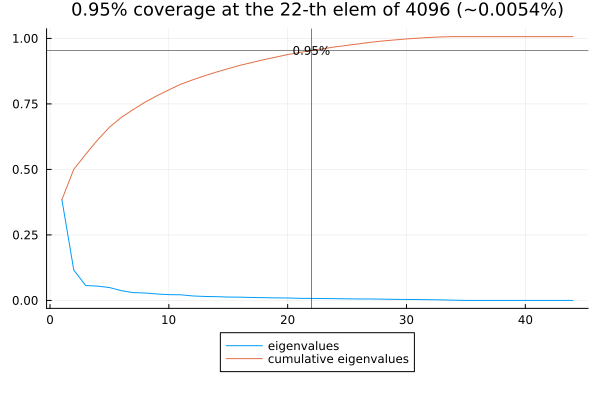

In [234]:
cumulative_eigenvalues = cumsum(eigenvalues ./ sum(eigenvalues))
index_X_percent = findfirst(cumulative_eigenvalues .>= X_percent)

# To put X_percent in the middle
x_range = 1:index_X_percent * 2

# Plot 2 curves con el rango x limitado
plot(
    [eigenvalues[x_range] ./ sum(eigenvalues)], 
    label="eigenvalues",
    title="$(X_percent)% coverage at the $index_X_percent-th elem of $(size(eigenvalues, 1)) (~$(round(index_X_percent/(size(eigenvalues, 1)), digits=4))%)",
    legend=:outerbottom,
    titlefontsize=12
)

# Plot cumulative eigenvalues con el rango x limitado
plot!(cumulative_eigenvalues[x_range], label="cumulative eigenvalues")

# Add X% text
annotate!([(index_X_percent, cumulative_eigenvalues[index_X_percent], text("$(X_percent)%", 8))])

# Add x line
vline!([index_X_percent], line=:black, linewidth=0.5, label=nothing)

# Add y line
hline!([cumulative_eigenvalues[index_X_percent]], line=:black, linewidth=0.5, label=nothing)

# Recognition

In [1]:
#show_training_images(training_images)

In [2]:
#show_testing_images(testing_images)

#### Setup data first:

In [293]:
n_folders = 2
n_training_images = 4
n_testing_images = 4

min_images_per_folder = n_training_images + n_testing_images + 1; # +1 because google drive creating desktop.ini

# Selecting the top {X_percent}% of the eigenvalues
X_percent = 99
X_percent = X_percent / 100

0.99

In [294]:
# Check if there are as many folder after the filter using: min_images_per_folder
println("We want $n_folders folders with $(min_images_per_folder-1) min_images_per_folder, we have: $(size(get_useful_folders(min_images_per_folder), 1))")

We want 2 folders with 8 min_images_per_folder, we have: 217


#### Aux functions:

In [303]:
# Use k components to test accuracy.

#                |  k=1    |    k=2   |   ...   |  k = index_X_percent |
#----------------------------------------------------------------------|
# Test_image_1   |  error  |   error  |  ...    |        error         |
#----------------------------------------------------------------------|
# Test_image_2   |  error  |   error  |  ...    |        error         |
#----------------------------------------------------------------------|
#        ...     |   ...   |    ...   |   ...   |        ...           |
#----------------------------------------------------------------------|
# Test_image_M   |  error  |   error  |  ...    |        error         |
#-----------------------------------------------------------------     |

function test_for_k_components(A, eigenfaces, random_n_folders, display_data)
    P = transpose(eigenfaces)*transpose(A);

    correct = 0.0
    all_min_dif = [] # We collect all the min norm diff
    for w in 1:size(testing_images,1)
        x_i = testing_images[w,:]' - μ
        P_i = transpose(eigenfaces) * transpose(x_i);

        dist=[]
        for j in 1:size(P,2)
            push!(dist, norm(P[:,j] - P_i))
        end
        pred = argmin(dist)
        push!(all_min_dif, dist[pred])

        celeb_tested = random_n_folders[ div(w - 1, n_testing_images) + 1 ]            
        celeb_predicted = random_n_folders[ div(pred - 1, n_training_images) + 1 ]
        
        if (celeb_tested == celeb_predicted)
            correct+=1
        end   
                
        if display_data == true
            println("_________________________________")
            println("Current: $celeb_tested (#$w)")
            println("Pred:    $celeb_predicted (#$pred)")

            println("Correct: $(correct/w*100)% ")

            IJulia.display([
                Gray.(reshape(testing_images[w,:], image_size, image_size)),
                Gray.(reshape(training_images[pred,:], image_size, image_size))
            ])
        end
    end
            
    accurracy = correct/size(testing_images,1)*100
    (accurracy, vec(all_min_dif))
end


test_for_k_components (generic function with 4 methods)

#### Run block:

In [305]:
# Testing for the {X_percent}%
cumulative_eigenvalues = cumsum(eigenvalues ./ sum(eigenvalues))
index_X_percent = findfirst(cumulative_eigenvalues .>= X_percent)

# Table format for {accuracy_by_precision}

#           |  Float16  |  Float32  |  Float64  |
#-----------|-----------|-----------|-----------|
#    k=1    | correct%  | correct%  | correct%  |
#    k=2    | correct%  | correct%  | correct%  |
#    ...    |   ...     |   ...     |   ...     |
#   k = X%  | correct%  | correct%  | correct%  |

# The data:
accuracy_by_precision = zeros(Float64, index_X_percent, 3)
recognition_dif_by_precision = []

# The training set (USE THE SAME FOR EVERY PRECISION)
training_set = get_random_n_folders(min_images_per_folder)

# TODO: Iterations

for (col, used_precision) in enumerate(precisions)
    ((training_images, testing_images), μ, A, eigenvalues, eigenvectors, elapsed_time, mem_used) = setup_basics(used_precision, training_set);

    recognition_diff = zeros(Float64, n_folders*n_training_images, index_X_percent)
    
    for k in 1:index_X_percent

        (accuracy, diff) = test_for_k_components(A, eigenvectors[:,1:k], training_set, false)

        accuracy_by_precision[k,col] = accuracy
        recognition_diff[:,k] = diff
        
    end
    
    push!(recognition_dif_by_precision, recognition_diff)
end

In [290]:
accuracy_by_precision

141×3 Matrix{Float64}:
  4.16667   5.83333   5.83333
 20.0      20.0      20.0
 16.6667   16.6667   16.6667
 19.1667   19.1667   19.1667
 22.5      22.5      22.5
 19.1667   20.0      20.0
 22.5      22.5      22.5
 28.3333   28.3333   28.3333
 25.8333   25.8333   25.8333
 21.6667   21.6667   21.6667
 24.1667   24.1667   24.1667
 26.6667   26.6667   26.6667
 23.3333   23.3333   23.3333
  ⋮                  
 28.3333   28.3333   28.3333
 28.3333   28.3333   28.3333
 26.6667   26.6667   26.6667
 26.6667   26.6667   26.6667
 28.3333   28.3333   28.3333
 30.0      28.3333   28.3333
 28.3333   28.3333   28.3333
 28.3333   28.3333   28.3333
 30.0      30.0      30.0
 30.0      30.0      30.0
 30.0      30.0      30.0
 26.6667   26.6667   26.6667

In [311]:
recognition_dif_by_precision[3]

8×7 Matrix{Float64}:
 2.57871   4.73388  5.45372  5.80264   6.77594   7.03016   9.13311
 1.26411   4.77071  6.41654  6.95248   7.19784   7.25538   8.5747
 0.853242  4.58816  4.59601  6.89285   7.01152   7.75806   9.83132
 1.12803   6.39193  7.01268  7.54881   9.37023  12.9191   12.9192
 1.99649   6.90065  7.0061   9.29712  11.2515   13.0193   13.3649
 1.41586   3.09013  6.2495   6.76647   7.09306  11.8349   11.8863
 1.57761   5.06197  8.04639  8.6697    9.9395   12.3588   12.5065
 0.742513  3.9326   8.16202  8.54763   8.8349   11.2734   11.6616

In [312]:
recognition_dif_by_precision[2]

8×7 Matrix{Float64}:
 2.57871   4.73388  5.45373  5.80264   6.77595   7.03017   9.13311
 1.26411   4.77072  6.41655  6.95248   7.19785   7.25539   8.5747
 0.853242  4.58816  4.59602  6.89285   7.01152   7.75806   9.83132
 1.12803   6.39193  7.01269  7.54881   9.37024  12.9191   12.9192
 1.99649   6.90066  7.0061   9.29713  11.2515   13.0193   13.3649
 1.41586   3.09013  6.2495   6.76646   7.09306  11.8349   11.8863
 1.57761   5.06197  8.0464   8.6697    9.93951  12.3588   12.5065
 0.742516  3.93261  8.16202  8.54763   8.8349   11.2734   11.6616

In [313]:
recognition_dif_by_precision[1]

8×7 Matrix{Float64}:
 2.57812   4.73438  5.45703  5.80859   6.78125   7.03516   9.13281
 1.25781   4.77734  6.42578  6.96094   7.20703   7.26562   8.58594
 0.863281  4.58203  4.58984  6.89062   7.00781   7.75391   9.83594
 1.12109   6.38672  7.00781  7.54297   9.36719  12.9219   12.9219
 1.99609   6.90234  7.00781  9.29688  11.25     13.0312   13.375
 1.39844   3.08594  6.24609  6.76172   7.08594  11.8438   11.8984
 1.59375   5.05078  8.04688  8.67969   9.91406  12.3594   12.5156
 0.734375  3.92578  8.15625  8.53906   8.82812  11.2734   11.6641

#### Comparison

In [330]:
# Working with eps 64
epsilon = eps(Float64)

# Abs diff bigger than eps? (64 vs 16)
result = abs.(recognition_dif_by_precision[3] - recognition_dif_by_precision[1]) .> epsilon

# Results
println(result)

Bool[1 1 1 1 1 1 1; 1 1 1 1 1 1 1; 1 1 1 1 1 1 1; 1 1 1 1 1 1 1; 1 1 1 1 1 1 1; 1 1 1 1 1 1 1; 1 1 1 1 1 1 1; 1 1 1 1 1 1 1]


In [246]:
"""
DATA FRAMES ---> EXCEL

# Define DF
df = DataFrame(
    used_precision = UInt8[],
    image_size = UInt16[],
    n_folders = UInt16[],
    n_training_images = UInt8[],
    n_testing_images = UInt8[],
    eigen_elapsed_time = Float64[],
    used_eigenfaces = UInt8[],
    norm_error = Float64[],
    acurracy = Float16[]
)

# Define a row
row_dict = Dict{String, Any}()

# Save data
row_dict["used_precision"] = p
row_dict["image_size"] = image_size
row_dict["persons"] = used_persons
row_dict["images_db"] = images_to_db
row_dict["images_to_test"] = images_to_test
row_dict["covariance_calc_time"] = covariance_elapsed_time
row_dict["eigen_elapsed_time"] = eigen_elapsed_time
row_dict["used_eigenfaces"] = n_components
row_dict["norm_error"] = error
row_dict["acurracy"] = acurracy

# Push to DF
push!(df, row_dict)

# Write excel
XLSX.writetable("eigenframe.xlsx", df, overwrite=true, sheetname="Recognition")
""";